In [1]:
from __future__ import division

import os
import re
import math
import time
import nltk
import string
import random
import codecs
import numpy as np
import itertools as it
import tensorflow as tf
import cPickle as pickle
import scipy.sparse as ss
import matplotlib.pyplot as plt
import tensorflow.contrib.seq2seq as seq2seq

from tqdm import tqdm
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.python.layers import core as layers_core
from tensorflow.contrib.layers import safe_embedding_lookup_sparse
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple, GRUCell

from src.helpers import *

In [ ]:
def load_corpus(file_path):
    """ Load corpus from text file and tokenize """
    corpus = []
    vocab_cnt = Counter()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    
    with codecs.open(file_path, 'r', encoding='utf-8') as fd:
        for line in fd:
            # clean lines from any punctuation characters
            clean_line = re.sub('[\+\-\.\,\:\;\"\?\!\>\<\=\(\)\n]+', '', line)
            tokens = tokenizer.tokenize(clean_line.lower())
            corpus.append(tokens)
            vocab_cnt.update(tokens)
            
    return corpus, vocab_cnt


def code_tokens(vocab_cnt, max_size=30000, unk_symbol='<unk>'):
    """ Filter vocabulary and encode tokens """
    vocab = ['<pad>', '<sos>', '<eos>', '<unk>']
    vocab.extend([word for word, _ in vocab_cnt.most_common(max_size)])
    vocab_enc = {token: ix for ix, token in enumerate(vocab)}
    vocab_dec = {ix: token for token, ix in vocab_enc.iteritems()}
    
    return vocab, vocab_enc, vocab_dec


def generate_context_data(corpus, max_window_size=5, skip_size=1, flatten=True):
    """ Generate data with context in format (target, [contexts]) or (target, context) """
    for center_ix in xrange(max_window_size, len(corpus)-max_window_size, skip_size):
        # sample a window size for the given center word
        window_size = np.random.randint(max_window_size) + 1
        full_context = corpus[center_ix-window_size:center_ix] + corpus[center_ix+1: center_ix+window_size+1]
        
        if flatten:
            for context_ix in xrange(2*window_size):
                yield (corpus[center_ix], full_context[context_ix])
        else:
            yield(corpus[center_ix], full_context)


def pad_data(data_arr, append_pre=[], append_suf=[], max_length=None):
    """ Pad sequences to length of longest sequence in batch. Possibly append or prepend tokens """
    data_arr = [append_pre + row + append_suf for row in data_arr]
    lengths = [len(row) for row in data_arr]
    max_len = max(lengths) if not max_length else max_length
    return np.array([row+[0]*(max_len-length) for row, length in zip(data_arr, lengths)]), lengths
    
                
def batchify_data(data_generator, batch_size):
    """ Split dataset (generator) into batches """
    if isinstance(data_generator, list):
        for ix in xrange(0, len(data_generator), batch_size):
            buff = data_generator[ix:ix+batch_size]
            yield buff
    else:
        while data_generator:
            buff = []
            for ix in xrange(0, batch_size):
                buff.append(next(data_generator))
            yield buff
            
            
def toy_data_generator(vocab_size, data_size, max_seq_length, reserved_digits=3):
    """ Generate toy data of integers up to Vocab Size """
    for _ in xrange(data_size):
        seq_length = np.random.randint(max_seq_length) + 1
        output = [np.random.randint(vocab_size-reserved_digits)+reserved_digits for _ in xrange(seq_length)]
        yield (output, output)


def save_embeddings(embeddings_obj, file_name):
    """ Save word embeddings and helper structures """
    with open(file_name, 'wb') as fd:
        pickle.dump(embeddings_obj, fd)
    

def load_embeddings(file_name):
    """ Load word embeddings and helper structures """
    with open(file_name, 'r') as fd:
        embeddings_obj = pickle.load(fd)
    return embeddings_obj
    
    
def get_tsne_embeddings(embedding_matrix):
    """ Compute t-SNE representation of embeddings """
    tsne = TSNE(perplexity=25, n_components=2, init='pca', n_iter=5000)
    return tsne.fit_transform(embedding_matrix)


def get_pca_embeddings(embedding_matrix):
    """ Compute PCA representation of embeddings """
    pca = PCA(n_components=2)
    return pca.fit_transform(embedding_matrix)


def plot_embeddings(embeddings, words=[], words_cnt=500, method='pca', figsize=(8,8)):
    """ Plot subset of embeddings in 2D space using t-SNE or PCA """
    embedding_matrix = embeddings._embeddings
    vocab_dec = embeddings._vocab_dec
    vocab_enc = embeddings._vocab_enc
    
    # prepare data
    if not words:
        vocab_size = embedding_matrix.shape[0]
        ixs = range(vocab_size)
        random.shuffle(ixs)
        chosen_ixs = ixs[:words_cnt]
        labels = [vocab_dec[ix] for ix in chosen_ixs]
        word_vecs = embedding_matrix[chosen_ixs]
    else:
        labels = words
        chosen_ixs = [vocab_enc[word] for word in words]
        word_vecs = embedding_matrix[chosen_ixs]
        
    if method == 'tsne':
        low_dim_embeddings = get_tsne_embeddings(word_vecs)
    else:
        low_dim_embeddings = get_pca_embeddings(word_vecs)
        
    # plot reduced vectors
    plt.figure(figsize=figsize)
    
    for embedding, label in zip(low_dim_embeddings, labels):
        x, y = embedding[0], embedding[1]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), 
                     textcoords='offset points', ha='right', 
                     va='bottom')
    plt.yticks=[]
    plt.xticks=[]
    plt.grid()
    plt.show()
    

class Embeddings(object):
    """ Class wrapping word embeddings """
    def __init__(self, embedding_matrix, vocab_enc, vocab_dec):
        self._embeddings = embedding_matrix
        self._vocab_enc = vocab_enc
        self._vocab_dec = vocab_dec
    
    def find_embedding(self, word):
        """ Find embedding for a given word """
        if isinstance(word, str):
            word = self._vocab_enc[word]
        return self._embeddings[word]
    
    def find_neighbors(self, word, k=5, nearest=True, exclude=[], include_scores=False):
        """ Find neighboring words (semantic regularities) """
        word_ix = self._vocab_enc[word]
        exclude = exclude + [word_ix]
        
        # find neighbors
        word_emb = self._embeddings[word_ix]
        similarities = self._embeddings.dot(word_emb)
        similarities[exclude] = 0
        best_matches = np.argsort(similarities)
        trimmed_matches = best_matches[-k:][::-1] if nearest else best_matches[:k]
        return [(self._vocab_dec[word_ix], similarities[word_ix]) for word_ix in trimmed_matches]
    
    def find_analogous(self, word_a, word_b, word_c, k=5):
        """ Find analogous word (syntactic regularities: word_a - word_b = x - word_c) """
        word_a_ix, word_b_ix, word_c_ix = [self._vocab_enc[word] for word in [word_a, word_b, word_c]]
        exclude = [word_a_ix, word_b_ix, word_c_ix]
        
        emb_a = self.find_embedding(word_a_ix) 
        emb_b = self.find_embedding(word_b_ix) 
        emb_c = self.find_embedding(word_c_ix) 
        emb_d_hat = emb_a - emb_b + emb_c
        similarities = self._embeddings.dot(emb_d_hat)
        similarities[exclude] = 0
        best_matches = np.argsort(similarities)
        trimmed_matches = best_matches[-k:][::-1]
        return [(self._vocab_dec[word_ix], similarities[word_ix]) for word_ix in trimmed_matches]
    
    def vocab(self):
        """ Return vocabulary list """
        return self._vocab_enc.keys()

Corpus A size (total tokens): 177655
Corpus A vocabulary size (distinct tokens): 23614
Most popular words (corpus A): [(u'w', 6558), (u'i', 5091), (u'na', 3013), (u'z', 2633), (u'\u017ce', 2189)]

Corpus B size (total tokens): 209813
Corpus B vocabulary size (distinct tokens): 11012
Most popular words (corpus B): [(u'the', 15602), (u'of', 8042), (u'to', 6611), (u'and', 6587), (u'in', 4925)]


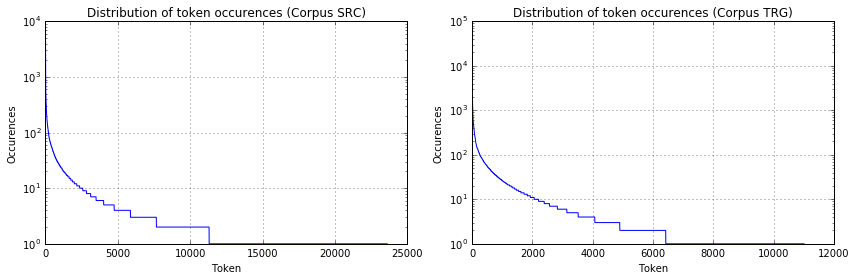

In [2]:
# CORPUS_A_PATH, CORPUS_B_PATH = './corpora/europarl.de-en.de', './corpora/europarl.de-en.en'
CORPUS_A_PATH, CORPUS_B_PATH = './corpora/europarl.pl-en.pls', './corpora/europarl.pl-en.ens'

# LOAD CORPUS
corpus_a, vocab_cnt_a = load_corpus(CORPUS_A_PATH)
corpus_b, vocab_cnt_b = load_corpus(CORPUS_B_PATH)

raw_corpus_a_size = sum(vocab_cnt_a.itervalues())
raw_vocab_a_size = len(vocab_cnt_a)
raw_corpus_b_size = sum(vocab_cnt_b.itervalues())
raw_vocab_b_size = len(vocab_cnt_b)

print 'Corpus A size (total tokens):', raw_corpus_a_size
print 'Corpus A vocabulary size (distinct tokens):', raw_vocab_a_size
print 'Most popular words (corpus A):', vocab_cnt_a.most_common(5)
print
print 'Corpus B size (total tokens):', raw_corpus_b_size
print 'Corpus B vocabulary size (distinct tokens):', raw_vocab_b_size
print 'Most popular words (corpus B):', vocab_cnt_b.most_common(5)

# visualize distribution
counts_a = sorted(vocab_cnt_a.itervalues(), reverse=True)
counts_b = sorted(vocab_cnt_b.itervalues(), reverse=True)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.semilogy(range(len(counts_a)), counts_a)
plt.title('Distribution of token occurences (Corpus SRC)')
plt.xlabel('Token')
plt.ylabel('Occurences')
plt.grid()
plt.subplot(122)
plt.semilogy(range(len(counts_b)), counts_b)
plt.title('Distribution of token occurences (Corpus TRG)')
plt.xlabel('Token')
plt.ylabel('Occurences')
plt.tight_layout()
plt.grid()
plt.show()

In [3]:
# LIMIT VOCABS
LANG_A_TOKEN_LIMIT = 45000
vocab_a, vocab_enc_a, vocab_dec_a = code_tokens(vocab_cnt_a, LANG_A_TOKEN_LIMIT)
corpus_a_enc = [[vocab_enc_a[word] for word in sentence if word in vocab_enc_a] for sentence in corpus_a]

LANG_B_TOKEN_LIMIT = 25000
vocab_b, vocab_enc_b, vocab_dec_b = code_tokens(vocab_cnt_b, LANG_B_TOKEN_LIMIT)
corpus_b_enc = [[vocab_enc_b[word] for word in sentence if word in vocab_enc_b] for sentence in corpus_b]

print 'Clean corpus A size (total sentences):', len(corpus_a_enc)
print 'Clean corpus A vocabulary size (distinct tokens):', len(vocab_a)
print
print 'Clean corpus B size (total sentences):', len(corpus_b_enc)
print 'Clean corpus B vocabulary size (distinct tokens):', len(vocab_b)

Clean corpus A size (total sentences): 10000
Clean corpus A vocabulary size (distinct tokens): 23618

Clean corpus B size (total sentences): 10000
Clean corpus B vocabulary size (distinct tokens): 11016


In [ ]:
corpus_par = zip(corpus_a_enc, corpus_b_enc)
length_diff = Counter([abs(len(a) - len(b)) for a, b in corpus_par])

print 'Max length diff:', max(length_diff.keys())
print 'Avg length diff:', sum(length_diff.keys()) / len(corpus_par)

keys, values = zip(*sorted(length_diff.iteritems(), key=lambda x: x[0]))
plt.figure(figsize=(6, 4))
plt.semilogy(keys, values)
plt.title('Distribution of length differences (Corpus Parallel)')
plt.xlabel('Length Difference')
plt.ylabel('Occurences')
plt.grid()
plt.show()

In [ ]:
class SeqToSeq(object):
    def __init__(self, src_vocab_size, trg_vocab_size, emb_size=100, enc_units=100, dec_units=100, 
                 num_layers=1, bi_dir=False, learning_rate=1e-3, pad_token=0, eos_token=2):
        self.src_vocab_size = src_vocab_size
        self.trg_vocab_size = trg_vocab_size
        self.emb_size = emb_size
        self.enc_units = enc_units
        self.dec_units = dec_units
        self.num_layers = num_layers
        self.bi_dir = bi_dir
        self.learning_rate = learning_rate
        self.pad_token = pad_token
        self.eos_token = eos_token
        
        self._build_model()
        
    def _init_placeholders(self):
        with tf.variable_scope('placeholders') as scope:
            self.enc_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
            self.dec_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')
            self.dec_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

            self.enc_inputs_len = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_len')
            self.dec_inputs_len = tf.placeholder(shape=(None,), dtype=tf.int32, name='decoder_inputs_len')
            self.max_dec_inputs_len = tf.reduce_max(self.dec_inputs_len, name='max_decoder_inputs_len')
            
            self.avg_eval_loss = tf.placeholder_with_default(0.0, shape=None, name='avg_eval_loss')
            
    def _init_variables(self):
        # define global variables
        self.global_step = tf.Variable(
            initial_value=0, 
            trainable=False, 
            name='global_step')
        
        # define embeddings and lookup
        with tf.variable_scope('embeddings') as scope:
            self.embeddings_src = tf.Variable(
                tf.random_uniform([self.src_vocab_size, self.emb_size], -0.25, 0.25), 
                dtype=tf.float32,
                name='embeddings_src')
            self.embeddings_trg = tf.Variable(
                tf.random_uniform([self.trg_vocab_size, self.emb_size], -0.25, 0.25), 
                dtype=tf.float32,
                name='embeddings_trg')
    
    def _init_encoder(self):
        with tf.variable_scope('encoder') as scope:
            enc_inputs_emb = tf.nn.embedding_lookup(self.embeddings_src, self.enc_inputs)
            enc_cell = tf.contrib.rnn.GRUCell(self.enc_units)
            _, self.enc_final_state = tf.nn.dynamic_rnn(
                cell=enc_cell, 
                inputs=enc_inputs_emb, 
                sequence_length=self.enc_inputs_len, 
                time_major=False, 
                dtype=tf.float32, 
                scope='encoder_cell')
        
    def _init_decoder(self):
        # training decoder
        with tf.variable_scope('decoder') as scope:
            dec_inputs_emb = tf.nn.embedding_lookup(self.embeddings_trg, self.dec_inputs)
            dec_out_layer = layers_core.Dense(self.trg_vocab_size)
            dec_cell = tf.contrib.rnn.GRUCell(self.dec_units)

            dec_train_helper = tf.contrib.seq2seq.TrainingHelper(
                inputs=dec_inputs_emb,
                sequence_length=self.dec_inputs_len,
                time_major=False,
                name='training_helper')

            dec_train_decoder = seq2seq.BasicDecoder(
                cell=dec_cell,
                helper=dec_train_helper,
                initial_state=self.enc_final_state,
                output_layer=dec_out_layer)

            self.dec_train_outputs = seq2seq.dynamic_decode(
                decoder=dec_train_decoder,
                output_time_major=False,
                impute_finished=True,
                maximum_iterations=self.max_dec_inputs_len)[0]
            
            # inference decoder
            batch_size = tf.shape(self.enc_inputs)[0]
            eos_slice = tf.fill([batch_size], self.eos_token, name='EOS')

            dec_infer_helper = seq2seq.GreedyEmbeddingHelper(
                embedding=self.embeddings_trg,
                start_tokens=eos_slice,
                end_token=self.eos_token)

            dec_infer_decoder = seq2seq.BasicDecoder(
                cell=dec_cell,
                helper=dec_infer_helper,
                initial_state=self.enc_final_state,
                output_layer=dec_out_layer)

            self.dec_infer_outputs = seq2seq.dynamic_decode(
                decoder=dec_infer_decoder,
                output_time_major=False,
                impute_finished=True)[0]
    
    def _init_optimizer(self):
        with tf.variable_scope('optimization') as scope:
            dec_train_logits = tf.identity(self.dec_train_outputs.rnn_output)
            dec_infer_logits = tf.identity(self.dec_infer_outputs.rnn_output)
            self.dec_train_preds = self.dec_train_outputs.sample_id 
            self.dec_infer_preds = self.dec_infer_outputs.sample_id

            masks = tf.sequence_mask(
                lengths=self.dec_inputs_len, 
                maxlen=self.max_dec_inputs_len,
                dtype=tf.float32, 
                name='masks')

            self.loss = seq2seq.sequence_loss(
                logits=dec_train_logits,
                targets=self.dec_targets,
                weights=masks,
                average_across_timesteps=True,
                average_across_batch=True)

            # setup optimizer and training step
            self.opt = tf.train.AdamOptimizer(self.learning_rate)
            
            trainable_params = tf.trainable_variables()
            gradients = tf.gradients(self.loss, trainable_params)
            # add gradient clipping
            clip_gradients = gradients
            self.updates = self.opt.apply_gradients(
                zip(clip_gradients, trainable_params), 
                global_step=self.global_step)
    
            # summaries
            self.train_summary = tf.summary.scalar('train_loss', self.loss)
            self.valid_summary = tf.summary.scalar('valid_loss', self.loss)
            self.avg_valid_summary = tf.summary.scalar('avg_valid_loss', self.avg_eval_loss)
            
    def _build_model(self):
        self._init_placeholders()
        self._init_variables()
        self._init_encoder()
        self._init_decoder()
        self._init_optimizer()
        
        self.summary_op = tf.summary.merge_all()
    
    def _get_feed_dict(self, enc_in, enc_in_len, dec_in=None, dec_in_len=None, dec_out=None):
            feed_dict = { self.enc_inputs: enc_in, self.enc_inputs_len: enc_in_len}
            
            if dec_in is not None:
                feed_dict[self.dec_inputs] = dec_in
            if dec_in_len is not None:
                feed_dict[self.dec_inputs_len] = dec_in_len
            if dec_out is not None:
                feed_dict[self.dec_targets] = dec_out
                
            return feed_dict
    
    def train(self, sess, enc_inputs, enc_inputs_len, dec_inputs, dec_inputs_len, dec_targets):
        fd = self._get_feed_dict(enc_inputs, enc_inputs_len, 
                                 dec_inputs, dec_inputs_len, 
                                 dec_targets)
        
        operations = [self.updates, self.loss, self.train_summary, self.enc_final_state]
        _, l, s, e = sess.run(operations, fd)
        return l, s, e
    
    def evaluate(self, sess, enc_inputs, enc_inputs_len, dec_inputs, dec_inputs_len, dec_targets):
        fd = self._get_feed_dict(enc_inputs, enc_inputs_len, 
                                 dec_inputs, dec_inputs_len, 
                                 dec_targets)
        
        operations = [self.loss, self.valid_summary, self.dec_train_preds, self.enc_final_state]
        l, s, p, e = sess.run(operations, fd)
        return l, s, p, e
    
    def infer(self, sess, enc_inputs, enc_inputs_len):
        fd = self._get_feed_dict(enc_inputs, enc_inputs_len)
        return sess.run([self.dec_infer_preds], fd)
    
    def encode_seq(self, sess, enc_inputs, enc_inputs_len):
        fd = self._get_feed_dict(enc_inputs, enc_inputs_len)
        return sess.run([self.enc_final_state], fd)
    
    def save_model(self, sess, path):
        saver = tf.train.Saver()
        saver.save(sess, save_path=path, global_step=self.global_step)
    
    def restore_model(self, sess, path):
        saver = tf.train.Saver()
        saver.restore(sess, path)

### Toy Example - Reconstructing Sequence

In [ ]:
# EXPERIMENT PARAMETERS
VOCAB_SIZE = 10
BATCH_SIZE = 64
TRAIN_DATA_SIZE = 500000
VAL_DATA_SIZE = 500

NUM_LAYERS = 1
EMB_SIZE = 20
ENC_UNITS = 20
DEC_UNITS = ENC_UNITS
LEARNING_RATE = 0.001
HARD_MAX_LEN = 128

SUMM_INTERVAL = 100
EVAL_INTERVAL = 250
CKPT_INTERVAL = 1000

CKPT_PATH = './models/'
LOG_PATH = './logs/'
EXPERIMENT_NAME = 'toy-example'

# EXPERIMENT DATA
train_data = toy_data_generator(VOCAB_SIZE, TRAIN_DATA_SIZE, 15, 3)
eval_data = list(toy_data_generator(VOCAB_SIZE, VAL_DATA_SIZE, 15, 3))
vocab_dec_a = {ix: str(ix) for ix in xrange(11)}
vocab_dec_b = vocab_dec_a

### Europarl DE-EN Translation

In [ ]:
# EXPERIMENT PARAMETERS
VOCAB_SIZE_SRC = len(vocab_a)
VOCAB_SIZE_TRG = len(vocab_b)
BATCH_SIZE = 128

NUM_LAYERS = 1
EMB_SIZE = 100
ENC_UNITS = 200
DEC_UNITS = ENC_HIDDEN_UNITS
LEARNING_RATE = 0.001
HARD_MAX_LEN = 128

SUMM_INTERVAL = 100
EVAL_INTERVAL = 250
CKPT_INTERVAL = 1000

CKPT_PATH = './models/'
LOG_PATH = './logs/'
EXPERIMENT_NAME = 'ep-de'

# EXPERIMENT DATA
train_split, eval_split, test_split = 0.8, 0.1, 0.1
random.seed(1)
random.shuffle(corpora)
train_data = pass
eval_data = pass
test_data = pass

#### Run Experiments

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = SeqToSeq(VOCAB_SIZE, VOCAB_SIZE, EMB_SIZE, ENC_UNITS, DEC_UNITS, learning_rate=LEARNING_RATE)

try:
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter(
        os.path.join(LOG_PATH, EXPERIMENT_NAME + time.strftime("%Y-%m-%d-%H-%M-%S")),
        graph=sess.graph)
    
    while True:
        
        batches_gen = batchify_data(train_data, BATCH_SIZE)
        train_losses = []
        for data_batch in batches_gen: 
            batch_src, batch_trg = zip(*data_batch)
            
            # prepare batch
            enc_inp, enc_lengths = pad_data(batch_src, append_suf=[2])
            dec_inp, _ = pad_data(batch_trg, append_pre=[2])
            dec_trg, dec_lengths = pad_data(batch_trg, append_suf=[2])
            
            # training step
            if enc_inp.shape[1] > HARD_MAX_LEN: continue
            l, s, _ = model.train(sess, enc_inp, enc_lengths, dec_inp, dec_lengths, dec_trg)
            train_losses.append(l)
            
            # summarize, eval, etc.
            global_step = model.global_step.eval()
            
            if global_step % CKPT_INTERVAL == 0:
                ckpt_file = os.path.join(CKPT_PATH, EXPERIMENT_NAME + time.strftime("%Y-%m-%d-%H-%M-%S"))
                model.save_model(sess, ckpt_file)
                print 'Saved model...'
                
            if global_step == 1 or global_step % SUMM_INTERVAL == 0:
                summary_writer.add_summary(s, global_step)

            if global_step == 1 or global_step % EVAL_INTERVAL == 0:
                eval_losses = []
                for batch_data in batchify_data(eval_data, BATCH_SIZE): 
                    batch_src, batch_trg = zip(*data_batch)
                    enc_inp, enc_lengths = pad_data(batch_src, append_suf=[2])
                    dec_inp, _ = pad_data(batch_trg, append_pre=[2])
                    dec_trg, dec_lengths = pad_data(batch_trg, append_suf=[2])
                    l, _, p, _ = model.evaluate(sess, enc_inp, enc_lengths, dec_inp, dec_lengths, dec_trg)
                    eval_losses.append(l)
                    
                eval_s = sess.run(model.avg_valid_summary, {model.avg_eval_loss: np.mean(eval_losses)})
                summary_writer.add_summary(eval_s, global_step)
                
                print('batch {}'.format(global_step))
                print('train losses: {} / eval losses: {}'.format(np.mean(train_losses), np.mean(eval_losses)))
                for i, (inp, pred) in enumerate(zip(enc_inp, p)[:3]):
                    print('sample {}:'.format(i + 1))
                    print('input     >> {}'.format(' '.join([vocab_dec_a[word].encode('ascii', errors='replace') for word in inp])))
                    print('predicted >> {}'.format(' '.join([vocab_dec_b[word].encode('ascii', errors='replace') for word in pred])))
                    
                # clear train losses
                train_losses = []
        summary_writer.flush()
                    
except KeyboardInterrupt:
    model.save_model(sess, ckpt_file)
    summary_writer.close()
    print 'Training Interrupted'

In [ ]:
batch_data = [[3,4,6,8,9,2]]
enc_inp, enc_lengths = pad_data(batch_data, append_suf=[2])
print 'I >>', batch_data
print 'O >>', model.infer(sess, enc_inp, enc_lengths)[0]

batch_data = [[3,4,6,8,9], [3,4,6,8,8], [3,4,6,8,3], [5,5,5,6,7], [5,5,5,5,6,9], [2,2,2,2,4]]
enc_inp, enc_lengths = pad_data(batch_data, append_suf=[2])
data_enc = model.encode_seq(sess, enc_inp, enc_lengths)[0]
data_enc = data_enc / np.linalg.norm(data_enc, axis=1, keepdims=True)
print 'Similarites:', data_enc.dot(data_enc[0].T)